In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models import *

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


In [3]:


# Function to load a batch file and return a dictionary
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load dataset, combine batches, split, and visualize images
def load_and_prepare_data():
    # Load and combine the training batches
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    # Split into training and validation sets (80-20 split)
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()

# Define transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    # Normalization only for 'train_Default' scenario
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}

# Adjusting the CIFAR10Dataset class initialization to accept 'data_mode'
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2: #half the data gets copied, then transformed with train transformer
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]

# Create datasets and DataLoader instances
datasets = {
    'train': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only']),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}

# Update loaders for each dataset
loaders = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Default):', len(loaders['train']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Original):', len(X_train))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Default): 625
Amount of Valid Data batches: 157
Amount of training images (Original): 40000
Amount of Validation images: 10000


# Load all Models


In [4]:
modelResnet2= Resnet2()
modelResnet3= Resnet3()
modelResnet4= Resnet4()
modelResnet5= Resnet5()

total_paramsResnet2 = sum(p.numel() for p in modelResnet2.parameters())
print(f"Total parameters Resnet2: {total_paramsResnet2}")

total_paramsResnet3 = sum(p.numel() for p in modelResnet3.parameters())
print(f"Total parameters Resnet3: {total_paramsResnet3}")

total_paramsResnet4 = sum(p.numel() for p in modelResnet4.parameters())
print(f"Total parameters Resnet4: {total_paramsResnet4}")

total_paramsResnet5 = sum(p.numel() for p in modelResnet5.parameters())
print(f"Total parameters Resnet5: {total_paramsResnet5}")


# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

modelResnet2.to(device)
modelResnet3.to(device)
modelResnet4.to(device)
modelResnet5.to(device)





Total parameters Resnet2: 2088266
Total parameters Resnet3: 2777674
Total parameters Resnet4: 3385162
Total parameters Resnet5: 3537354
NVIDIA GeForce RTX 4070


ResNet5(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training

Training ResNet2 with learning rate: 0.001
LR: 0.001, ResNet2, train - Epoch: 1 [6400/40000 (16%)]  Loss: 1.8596
LR: 0.001, ResNet2, train - Epoch: 1 [12800/40000 (32%)]  Loss: 1.5522
LR: 0.001, ResNet2, train - Epoch: 1 [19200/40000 (48%)]  Loss: 1.4072
LR: 0.001, ResNet2, train - Epoch: 1 [25600/40000 (64%)]  Loss: 1.3191
LR: 0.001, ResNet2, train - Epoch: 1 [32000/40000 (80%)]  Loss: 1.2500
LR: 0.001, ResNet2, train - Epoch: 1 [38400/40000 (96%)]  Loss: 1.1922
LR: 0.001, ResNet2, train - Epoch: 1 [40000/40000 (100%)]  Loss: 1.2087
ResNet2 - Epoch 1: Avg. Training Loss: 1.4212, Train Accuracy: 48.10%, Avg. Valid Loss: 1.3245, Valid Accuracy: 51.69%
Saved best model for ResNet2 at epoch 1
LR: 0.001, ResNet2, train - Epoch: 2 [6400/40000 (16%)]  Loss: 1.1150
LR: 0.001, ResNet2, train - Epoch: 2 [12800/40000 (32%)]  Loss: 1.0627
LR: 0.001, ResNet2, train - Epoch: 2 [19200/40000 (48%)]  Loss: 1.0025
LR: 0.001, ResNet2, train - Epoch: 2 [25600/40000 (64%)]  Loss: 1.0000
LR: 0.001, ResNet2

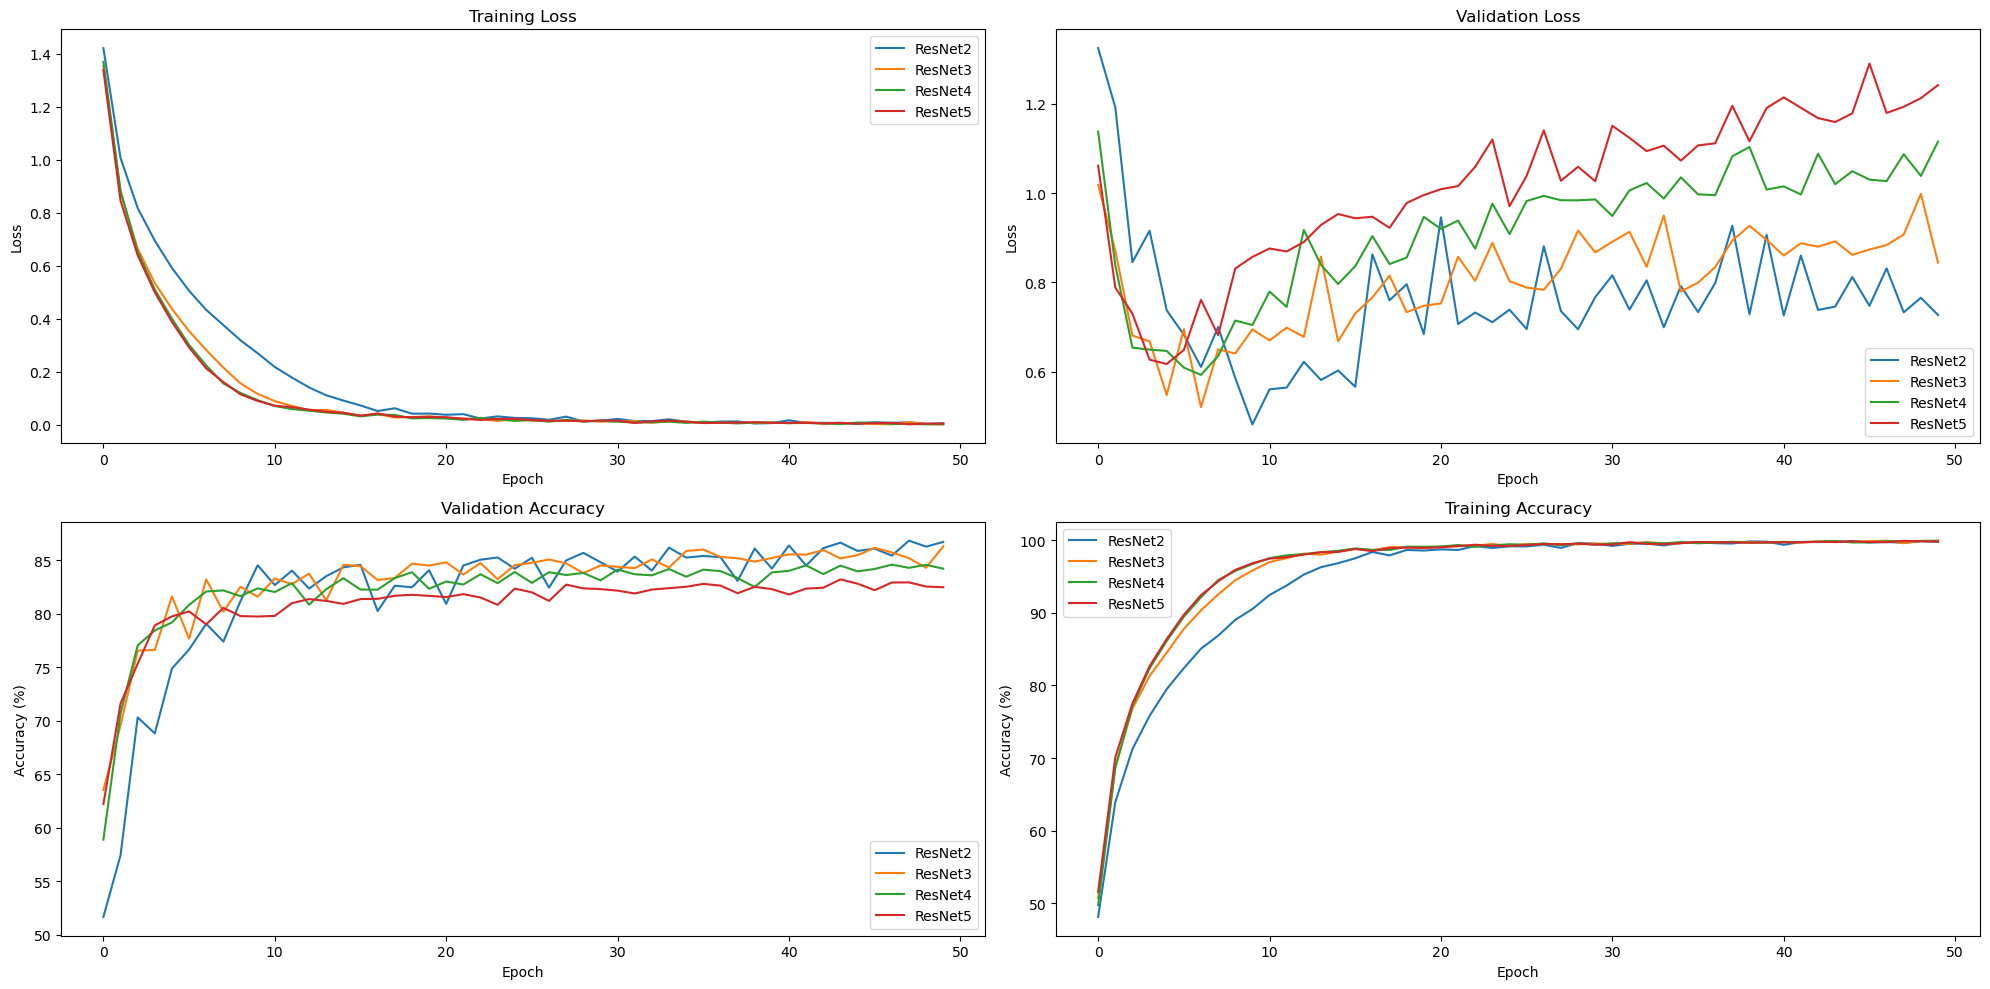

In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import time

def train_and_evaluate_model(model, model_name, loaders, device,loader_key, num_epochs=50, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = ExponentialLR(optimizer, gamma=0.98)

    train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history = [], [], [], []
    best_accuracy = 0.0
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, total_train_loss, total_correct_train, num_batches, num_train_examples = 0.0, 0.0, 0, 0, 0
        for i, (inputs, labels) in enumerate(loaders[loader_key]):
            inputs, labels = inputs.to(device), labels.to(device)
            labels =labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_loss += loss.item() * inputs.size(0)  # Correct loss accumulation
            num_batches += 1

            pred = outputs.argmax(dim=1)
            total_correct_train += (pred == labels).sum().item()
            num_train_examples += labels.size(0)
            if (i + 1) % 100 == 0 or i == len(loaders[loader_key]) - 1:
                print(f"LR: {learning_rate}, {model_name}, {loader_key} - Epoch: {epoch} [{(i + 1) * len(inputs)}/{len(loaders[loader_key].dataset)} "
                     f"({100. * (i + 1) / len(loaders[loader_key]):.0f}%)]  Loss: {running_loss / num_batches:.4f}")  # Corrected loss reporting
                running_loss, num_batches = 0.0, 0
        avg_train_loss = total_train_loss / num_train_examples  # Corrected average training loss
        train_loss_history.append(avg_train_loss)

        train_accuracy = (total_correct_train / num_train_examples) * 100  # Calculate training accuracy
        train_accuracy_history.append(train_accuracy)  # Store training accuracy per epoch

        model.eval()
        total_valid_loss, total_correct_valid, num_valid_batches = 0.0, 0, 0
        for inputs, labels in loaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item() * inputs.size(0)  # Correct loss accumulation
            pred = outputs.argmax(dim=1)
            total_correct_valid += (pred == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(loaders['valid'].dataset)  # Corrected average validation loss
        valid_loss_history.append(avg_valid_loss)

        valid_accuracy = (total_correct_valid / len(loaders['valid'].dataset)) * 100  # Calculate validation accuracy
        valid_accuracy_history.append(valid_accuracy)  # Store validation accuracy per epoch

        print(f"{model_name} - Epoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Avg. Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")

        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"Saved best model for {model_name} at epoch {epoch}")

        scheduler.step()

    execution_time = time.time() - start_time
    print(f"{model_name} - Execution time: {execution_time:.2f} seconds")

    return train_loss_history, valid_loss_history, valid_accuracy_history, train_accuracy_history


#-----

model_names = ['ResNet2', 'ResNet3', 'ResNet4', 'ResNet5']
models = [modelResnet2, modelResnet3, modelResnet4, modelResnet5]

# Initialize dictionaries to store the metrics
all_metrics = {
    model_name: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for model_name in model_names
}


fixed_learning_rate = 0.001  # Define the fixed learning rate

# Train and evaluate each model
for model, model_name in zip(models, model_names):
    print(f"Training {model_name} with learning rate: {fixed_learning_rate}")
    train_loss, valid_loss, valid_accuracy, train_accuracy = train_and_evaluate_model(
        model, model_name, loaders, device,'train', num_epochs=50, learning_rate=fixed_learning_rate
    )
    
    # Store metrics in the dictionary
    all_metrics[model_name]['train_losses'] = train_loss
    all_metrics[model_name]['valid_losses'] = valid_loss
    all_metrics[model_name]['valid_accuracies'] = valid_accuracy
    all_metrics[model_name]['train_accuracies'] = train_accuracy


plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics.items():
    plt.plot(metrics['train_losses'], label=name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for name, metrics in all_metrics.items():
    plt.plot(metrics['valid_losses'], label=name)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for name, metrics in all_metrics.items():
    plt.plot(metrics['valid_accuracies'], label=name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for name, metrics in all_metrics.items():
    plt.plot(metrics['train_accuracies'], label=name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Blocks Test

Blocks Combos to Test:

[4,4,3]

[3,4,3]

[4,3,3]

[3,3,3]

In [6]:

def Resnet3_443():
    return ResNet3(BasicBlock, [4,4,3])

modelResnet3_443 = Resnet3_443()

def Resnet3_343():
    return ResNet3(BasicBlock, [3,4,3])

modelResnet3_343 = Resnet3_343()

def Resnet3_433():
    return ResNet3(BasicBlock, [4,3,3])

modelResnet3_433 = Resnet3_433()

def Resnet3_453():
    return ResNet3(BasicBlock, [4,5,3])

modelResnet3_453 = Resnet3_453()

total_paramsResnet3_443 = sum(p.numel() for p in modelResnet3_443.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_443}")

total_paramsResnet3_343 = sum(p.numel() for p in modelResnet3_343.parameters())
print(f"Total parameters modelResnet3_443: {total_paramsResnet3_343}")

total_paramsResnet3_433 = sum(p.numel() for p in modelResnet3_433.parameters())
print(f"Total parameters modelResnet3_433: {total_paramsResnet3_433}")


total_paramsResnet3_453 = sum(p.numel() for p in modelResnet3_453.parameters())
print(f"Total parameters modelResnet3_453: {total_paramsResnet3_453}")

# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

modelResnet3_443.to(device)
modelResnet3_343.to(device)
modelResnet3_433.to(device)
# modelResnet3_333.to(device)
modelResnet3_453.to(device)



Total parameters modelResnet3_443: 4697162
Total parameters modelResnet3_443: 4623178
Total parameters modelResnet3_433: 4401738
Total parameters modelResnet3_453: 4992586
NVIDIA GeForce RTX 4070


ResNet3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

# Training

Training Resnet3_443 with learning rate: 0.001
LR: 0.001, Resnet3_443, train - Epoch: 1 [6400/40000 (16%)]  Loss: 1.9248
LR: 0.001, Resnet3_443, train - Epoch: 1 [12800/40000 (32%)]  Loss: 1.6419
LR: 0.001, Resnet3_443, train - Epoch: 1 [19200/40000 (48%)]  Loss: 1.4981
LR: 0.001, Resnet3_443, train - Epoch: 1 [25600/40000 (64%)]  Loss: 1.4067
LR: 0.001, Resnet3_443, train - Epoch: 1 [32000/40000 (80%)]  Loss: 1.2875
LR: 0.001, Resnet3_443, train - Epoch: 1 [38400/40000 (96%)]  Loss: 1.1885
LR: 0.001, Resnet3_443, train - Epoch: 1 [40000/40000 (100%)]  Loss: 1.1479
Resnet3_443 - Epoch 1: Avg. Training Loss: 1.4775, Train Accuracy: 45.13%, Avg. Valid Loss: 1.1532, Valid Accuracy: 57.45%
Saved best model for Resnet3_443 at epoch 1
LR: 0.001, Resnet3_443, train - Epoch: 2 [6400/40000 (16%)]  Loss: 1.0841
LR: 0.001, Resnet3_443, train - Epoch: 2 [12800/40000 (32%)]  Loss: 1.0515
LR: 0.001, Resnet3_443, train - Epoch: 2 [19200/40000 (48%)]  Loss: 1.0036
LR: 0.001, Resnet3_443, train - Epoch

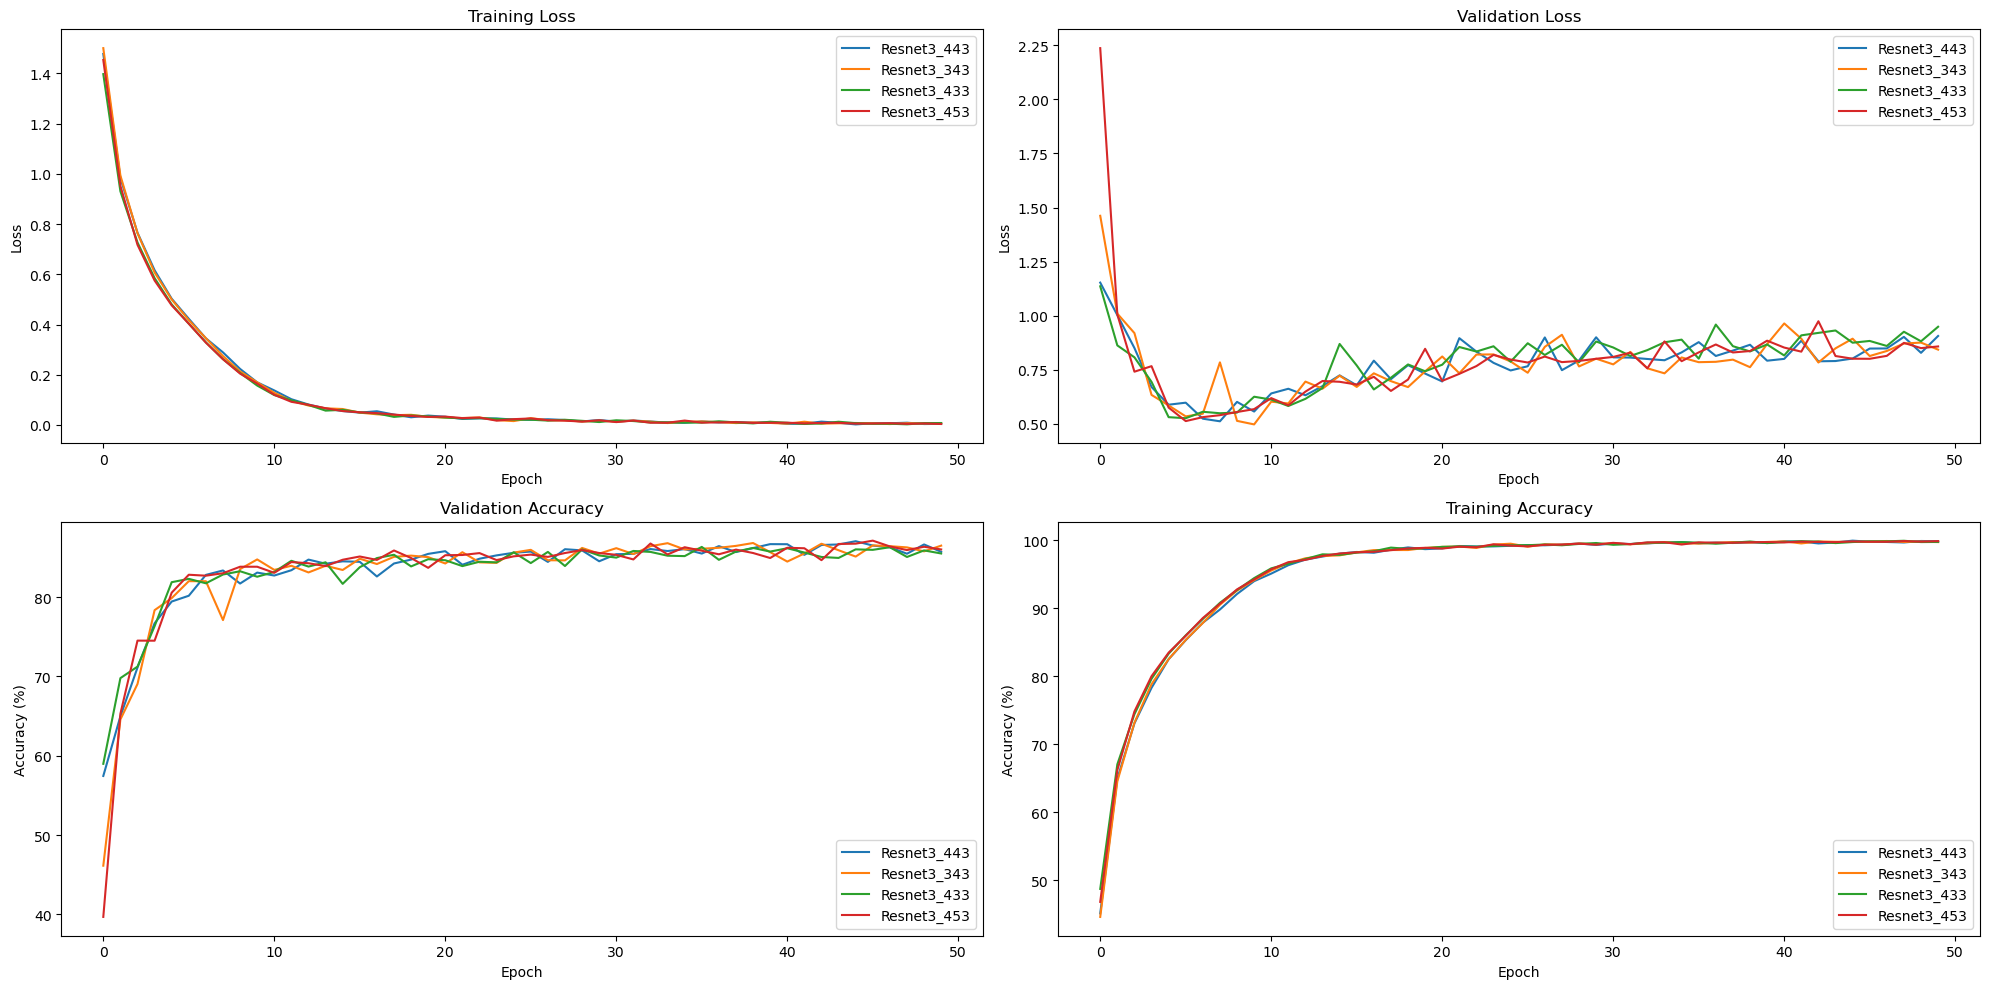

In [7]:

model_names = ['Resnet3_443', 'Resnet3_343', 'Resnet3_433', 'Resnet3_453']
models = [modelResnet3_443, modelResnet3_343, modelResnet3_433, modelResnet3_453]

# Initialize dictionaries to store the metrics
all_metrics = {
    model_name: {'train_losses': [], 'valid_losses': [], 'valid_accuracies': [], 'train_accuracies': []}
    for model_name in model_names
}


fixed_learning_rate = 0.001  # Define the fixed learning rate

# Train and evaluate each model
for model, model_name in zip(models, model_names):
    print(f"Training {model_name} with learning rate: {fixed_learning_rate}")
    train_loss, valid_loss, valid_accuracy, train_accuracy = train_and_evaluate_model(
        model, model_name, loaders, device,'train', num_epochs=50, learning_rate=fixed_learning_rate
    )
    
    # Store metrics in the dictionary
    all_metrics[model_name]['train_losses'] = train_loss
    all_metrics[model_name]['valid_losses'] = valid_loss
    all_metrics[model_name]['valid_accuracies'] = valid_accuracy
    all_metrics[model_name]['train_accuracies'] = train_accuracy


plt.figure(figsize=(20, 10))

# Training Loss
plt.subplot(2, 2, 1)
for name, metrics in all_metrics.items():
    plt.plot(metrics['train_losses'], label=name)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
for name, metrics in all_metrics.items():
    plt.plot(metrics['valid_losses'], label=name)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
for name, metrics in all_metrics.items():
    plt.plot(metrics['valid_accuracies'], label=name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 4)
for name, metrics in all_metrics.items():
    plt.plot(metrics['train_accuracies'], label=name)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Best Model Architecture From Tests:

Resnet with 3 Residual Layers and 4,4,3 Residual blocks in each Layer